# Clinical-bert classifier 

The goal of this notebook is to fine tune a pretrained [Clinical Bert model in spanish](https://huggingface.co/PlanTL-GOB-ES/roberta-base-biomedical-clinical-es) in a breast cancer mamography reports dataset in order to classify each report according to whether cancer was developed in the future or not. (binary classification).
The proposed architecture looks as follows: 



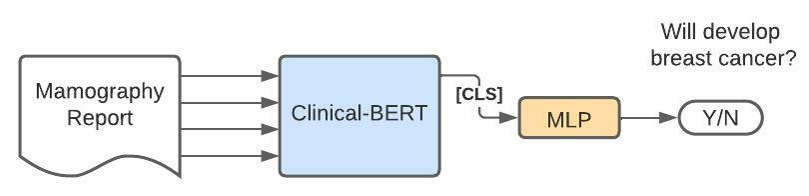

In [23]:
from datasets import load_dataset
from transformers import AutoModel
import torch
import numpy as np
import pandas as pd
model_ckpt="PlanTL-GOB-ES/roberta-base-biomedical-clinical-es" # Model ch

## Loading the dataset
This may be outsourced to a class of it's own or to the prepare script. 

In [24]:
train_path='../data/clean/BreastCancer_train.csv'
validation_path='../data/clean/BreastCancer_validation.csv'
test_path='../data/clean/BreastCancer_test.csv'

# Not currently using test because of few data
dataset=load_dataset('csv', data_files={'train': train_path, 'validation':validation_path}) 

Using custom data configuration default-6979c44da4f42a71
Reusing dataset csv (/home/jupyter/.cache/huggingface/datasets/csv/default-6979c44da4f42a71/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 2/2 [00:00<00:00, 331.03it/s]


In [25]:
# The target corresponds to column 'BRCAEvent
dataset

DatasetDict({
    train: Dataset({
        features: ['REPORT', 'BRCAEvent', 'Year', 'AGE', 'DaysToEvent'],
        num_rows: 165
    })
    validation: Dataset({
        features: ['REPORT', 'BRCAEvent', 'Year', 'AGE', 'DaysToEvent'],
        num_rows: 70
    })
})

## Preparing dataset

### Getting tokenizer features

In [26]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-biomedical-clinical-es')

In [27]:
def tokenize(batch):
    return tokenizer(batch['REPORT'],padding=True,truncation=True)

In [28]:
dataset_encoded=dataset.map(tokenize,batched=True)

100%|██████████| 1/1 [00:00<00:00, 78.85ba/s]


## Load the Model

In [29]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoModel.from_pretrained(model_ckpt).to(device)

## Extract hidden states

In [8]:
# Make the dataset into pytorch format
dataset_encoded.set_format('torch',columns=['input_ids','attention_mask'])

In [9]:
def get_contextual_embeddings(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in 
    tokenizer.model_input_names}
    with torch.no_grad():
        outputs=model(**inputs).last_hidden_state[:,0]
    return {'hidden_state':outputs.cpu().numpy()}
        
    

In [10]:
dataset_hidden=dataset_encoded.map(get_contextual_embeddings,batched=True)

100%|██████████| 1/1 [00:04<00:00,  4.79s/ba]


### Reduce dimentionality of the hidden states

In [11]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
reducer=UMAP()
reducer_cos=UMAP(metric='cosine')
scaler=StandardScaler()

hidden_states=np.array(dataset_hidden['train']['hidden_state'])
scaled_hidden_states=scaler.fit_transform(hidden_states)
reduced_hidden_states=reducer.fit_transform(scaled_hidden_states)
reduced_hidden_states_cos=reducer_cos.fit_transform(scaled_hidden_states)
labels=dataset['train']['BRCAEvent']
reduced_dataset=pd.DataFrame({'X':reduced_hidden_states[:,0], 
                              'Y': reduced_hidden_states[:,1],
                             'label':labels})
reduced_dataset_cos=pd.DataFrame({'X':reduced_hidden_states_cos[:,0], 
                              'Y': reduced_hidden_states_cos[:,1],
                             'label':labels})

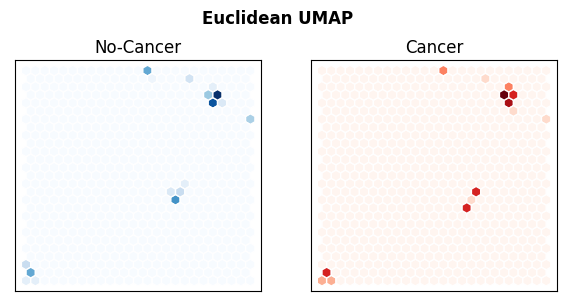

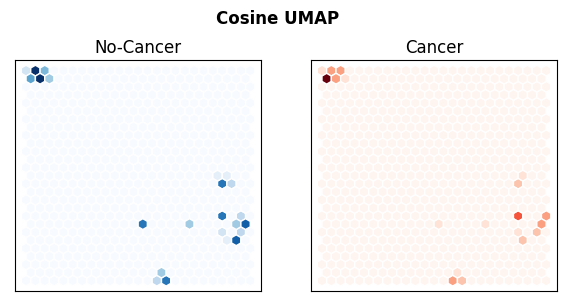

In [12]:

cmaps=['Blues','Reds']
labels=['No-Cancer','Cancer']

# Using euclidean mapping
fig, axes = plt.subplots(1,2,figsize=(7,3))
for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    sub_df=reduced_dataset.loc[reduced_dataset.label==i]
    axes[i].hexbin(sub_df['X'],sub_df['Y'],cmap=cmap,gridsize=24,edgecolors='white')
    axes[i].set_title(label)
    axes[i].set_xticks([]),axes[i].set_yticks([])
fig.suptitle('Euclidean UMAP',fontweight ="bold",y=1.05)
plt.show()

# Using cosine mapping
fig, axes = plt.subplots(1,2,figsize=(7,3))
for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    sub_df=reduced_dataset_cos.loc[reduced_dataset.label==i]
    axes[i].hexbin(sub_df['X'],sub_df['Y'],cmap=cmap,gridsize=24,edgecolors='white')
    axes[i].set_title(label)
    axes[i].set_xticks([]),axes[i].set_yticks([])
fig.suptitle('Cosine UMAP',fontweight ="bold",y=1.05)
plt.show()

### Try separation without fine tunning the BERT

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd


X_train=np.array(dataset_hidden['train']['hidden_state'])
X_validation=np.array(dataset_hidden['validation']['hidden_state'])

y_train=np.array(dataset_hidden['train']['BRCAEvent'])
y_validation=np.array(dataset_hidden['validation']['BRCAEvent'])

final=run_exps(X_train,y_train,X_validation,y_validation)

/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

LogReg
              precision    recall  f1-score   support

      benign       0.78      0.98      0.87        53
   malignant       0.67      0.12      0.20        17

    accuracy                           0.77        70
   macro avg       0.72      0.55      0.53        70
weighted avg       0.75      0.77      0.70        70

RF
              precision    recall  f1-score   support

      benign       0.75      0.91      0.82        53
   malignant       0.17      0.06      0.09        17

    accuracy                           0.70        70
   macro avg       0.46      0.48      0.45        70
weighted avg       0.61      0.70      0.64        70

KNN
              precision    recall  f1-score   support

      benign       0.78      0.94      0.85        53
   malignant       0.50      0.18      0.26        17

    accuracy                           0.76        70
   macro avg       0.64      0.56      0.56        70
weighted avg       0.71      0.76      0.71        70



/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/MLP/src/venv/lib/python3.7/site-packages/skl

SVM
              precision    recall  f1-score   support

      benign       0.76      1.00      0.86        53
   malignant       0.00      0.00      0.00        17

    accuracy                           0.76        70
   macro avg       0.38      0.50      0.43        70
weighted avg       0.57      0.76      0.65        70

GNB
              precision    recall  f1-score   support

      benign       0.71      0.47      0.57        53
   malignant       0.20      0.41      0.27        17

    accuracy                           0.46        70
   macro avg       0.46      0.44      0.42        70
weighted avg       0.59      0.46      0.50        70

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/to

In [14]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    target_names = ['benign', 'malignant']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [16]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=40, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

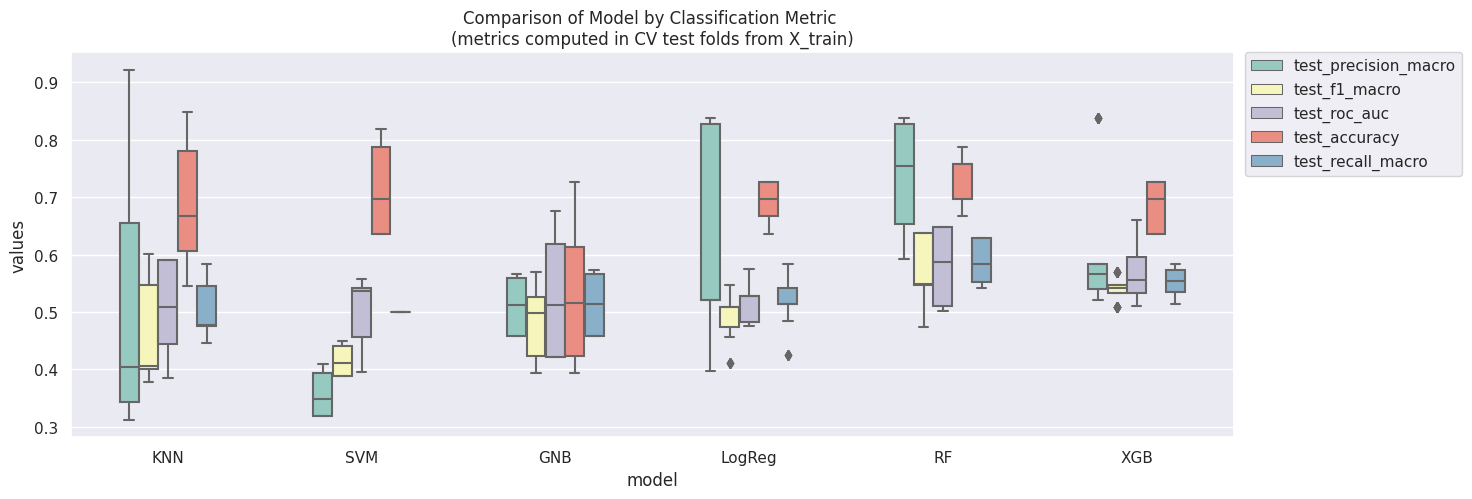

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3",width=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
plt.title('Comparison of Model by Classification Metric \n(metrics computed in CV test folds from X_train)')
plt.savefig('./benchmark_models_performance.png',dpi=300)

Notice strong class imbalance leads to poor results. 

# Finetuning Clinical-Bert model 

In [70]:
from transformers import AutoModelForSequenceClassification
num_labels=2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

## Define performance metrics


In [71]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels= pred.label_ids
    preds=pred.predictions.argmax(-1)
    f1=f1_score(labels,preds,average='weighted')
    acc=accuracy_score(labels,preds)
    return {'accuracy':acc,'f1':f1}

## Define a logging directory

In [72]:
from huggingface_hub import notebook_login
notebook_login()

## Define training arguments


In [73]:
from transformers import Trainer,TrainingArguments
batch_size=64
logging_steps=len(dataset_encoded['train'])//batch_size
model_name= f'{model_ckpt}-finetuned-cancer'
training_args=TrainingArguments(output_dir=model_name,
                                num_train_epochs=2,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy='epoch',
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=False,
                                log_level='error')

## train

In [ ]:
from transformers import Trainer
trainer= Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=dataset_encoded['train'], # remember that the dataset must be appropiately styled for the model
                 eval_dataset=dataset_encoded['validation'],
                 tokenizer=tokenizer
                 )
trainer.train()